In [1]:
import numpy as np
import pandas as pd
import math
from scipy import *
import sys
import quadpy
import numba 
from numba import jit
from scipy.integrate import quad
## set up of the parameters
spot = 13329.51953125
strike = 13329.51953125 * 2
expiry = 0.10
rate = 0
sigma = 0.80
M = 100000
## The main simulation loop
spotT = np.empty((M, ))
callT = np.empty((M, ))
for i in range(M):
    z = np.random.normal(size=1)
    spotT[i] = spot * np.exp((rate - 0.5 * sigma * sigma)* expiry + sigma * np.sqrt(expiry) * z)
    callT[i] = np.maximum(spotT[i] - strike, 0.0)
    price = np.exp(-rate * expiry) * callT.mean()
print("The Call Option Price is: {0:.3f}".format(price))

The Call Option Price is: 4.831


In [2]:
%%time
import numpy as np

def callTPayoff(spot, strike):
    return np.maximum(spot - strike, 0.0)

spot = 13329.51953125
strike = 13329.51953125
expiry = 1
rate = 0
vol = (0.20)**2
div = 0.0
kappa = 5
theta = (0.20)**2
sigma = 0.10

M = 1000000 # number of replications
N = int(round(252 * expiry,0))  # number of steps

dt = expiry / N

path = np.zeros(N)
var = np.zeros(N)
callT = np.zeros(M)
z1 = np.random.normal(size=(M,N))
z2 = np.random.normal(size=(M,N))

CPU times: user 14.7 s, sys: 1.15 s, total: 15.8 s
Wall time: 16.1 s


In [3]:
%%time
@jit(nopython=True, parallel=True,fastmath=True)
def Heston_computator(vol,kappa,theta,sigma,path,var,callT,z1,z2,strike,spot,rate,expiry):
    for i in numba.prange(M):
        var[0] = vol
        path[0] = spot
        for j in numba.prange(1,N):
            #simulate variance equation first
            var[j] = var[j-1] + kappa * (theta - var[j-1]) * dt + sigma * np.sqrt(var[j-1] * dt) * z1[i,j]
            path[j] = path[j-1] * np.exp((rate - div - 0.5 * var[j]) * dt + np.sqrt(var[j] * dt) * z2[i,j])
        callT[i] =  np.maximum(path[-1] - strike, 0.0)
    callT = np.mean(callT) * np.exp(-rate * expiry) 
    return callT

rm = Heston_computator(vol,kappa,theta,sigma,path,var,callT,z1,z2,strike,spot,rate,expiry)
result = rm
IT = M*N
fmt = "The value of the callT option is: {0:0.3f} with {1} iterations!!"
print(fmt.format(result,IT))

The value of the callT option is: 1060.890 with 252000000 iterations!!
CPU times: user 9.91 s, sys: 2.96 s, total: 12.9 s
Wall time: 2.68 s


In [4]:
from yahoo_fin.options import *
import yfinance as yf
from pandas import ExcelWriter
from yahoo_fin import stock_info as si
from pandas_datareader import data as wb
from datetime import timedelta, date
import matplotlib.pyplot as plt
from pandas_datareader import data as wb
from dateutil.parser import parse

In [5]:
L = pd.read_excel('/Users/elyes/Desktop/df_16_04_21.xlsx')
L.index = L['OPTION EXPIRY DATE']
L = L.drop(columns='OPTION EXPIRY DATE')

In [6]:
import datetime 
from datetime import date
L.iloc[:,1] = L.iloc[:,1]
L.iloc[:,2] = L.iloc[:,2]
#L = L.mask(L.Strikes>1.10 * S0).dropna()
#L = L.mask(L.Strikes<0.90 * S0).dropna()
L['Spread'] = abs(L.iloc[:,1] - L.iloc[:,2])
L['Mid Price'] = (L.iloc[:,1] + L.iloc[:,2])/2 
#L['Mid Price'] = (L.iloc[:,1] + L.iloc[:,2])/2  +
L.sort_index(inplace = True)
L = L.mask(L.Strikes > 4551).dropna()
Date_16_4_21 = pd.to_datetime(date(2021, 4, 16))
L['TTM'] =  (L.index - Date_16_4_21).days/360
#L = L.mask(L.TTM>400/365).dropna()

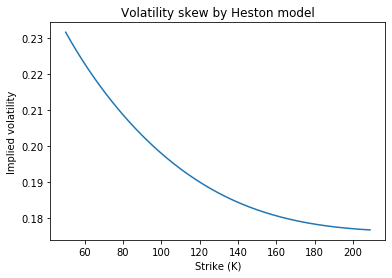

In [7]:
from scipy import *
from math import * 
from scipy.stats import norm
from scipy.optimize import fmin_bfgs
from scipy.optimize import brentq
from scipy.integrate import quad
from scipy.optimize import minimize, rosen, rosen_der,least_squares


#public
def call_price(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K,J):
    p1 = __p1(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K,J)
    p2 = __p2(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K,J)
    #print(p1,p2)
    C = s0 * p1 - K * np.exp(-r * T) * p2
    #C = np.maximum(s0 * np.maximum(p1,0) - K * np.exp(-r * T) * np.maximum(p2,0),0)
    return C

def integrandd(phi):
    A = np.exp(-1j *  phi * np.log(K[:]))
    C = __fm(phi, kappa, theta, sigma, rho, v0, r, T[:], s0, status)
    B = (1j * phi)
    return (A * C / B).real

#private
def __p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 , K, status,J):
    if J =='No':
        integrand = lambda phi: (np.exp(-1j * phi * np.log(K)) * __f(phi, kappa, theta, sigma, rho, v0, r, T, s0, status) /(1j * phi)).real
    else :
        def integrand(phi):
            #if len(phi) > 200:
            #    return 0
            A = np.array([np.exp(-1j * phi * np.log(i)) for i in K])
            C = np.array([__f(phi, kappa, theta, sigma, rho, v0, r,i, s0, status) for i in T])
            B = (1j * phi)
            return (A * C / B).real
    
    p = 0.50 + 1/pi * quad(integrand, 0.0, 100)[0]#, epsabs=1e-08, epsrel=1e-08, limit=100
    
    return p#quadpy.quad(integrand, 0.0, 100.0)[0]


    #return (0.5 + (1 / pi) * quad(integrand, 0, 100)[0])
def __p1(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K,J):
    return __p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K, 1,J)
def __p2(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K,J):
    return __p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K, 2,J)
def __fm(phi, kappa, theta, sigma, rho, v0, r, T, s0, status):
        
    if status == 1:
        u = 0.5
        b = kappa - rho * sigma
    else:
        u = -0.5
        b = kappa
    
    a = kappa * theta
    x = np.log(s0)
    d = np.sqrt((rho * sigma * phi * 1j - b)**2 - sigma**2 * (2 * u * phi * 1j - phi**2))
    g = (b - rho * sigma * phi * 1j + d) / (b - rho * sigma * phi * 1j - d)
    C = np.array([r * (phi * 1j * i) + (a / sigma**2)*((b - rho * sigma * phi * 1j + d) * i - 2 * np.log((1 - g * np.exp(d * i))/(1 - g))) for i in T])
    D = np.array([(b - rho * sigma * phi * 1j + d) / sigma**2 * ((1 - np.exp(d * i)) / (1 - g * np.exp(d * i))) for i in T])
    Final = np.exp(C + D * v0 + 1j * phi * x)
    return Final

def Optimisor(x,args):
    price_,S, K, T, r = args
    A = _price_(S, K, T, r, x)
    MNM = A - price_
    return MNM
#For Matrices

def __f(phi, kappa, theta, sigma, rho, v0, r, T, s0, status):
        
    if status == 1:
        u = 0.5
        b = kappa - rho * sigma
    else:
        u = -0.5
        b = kappa
    
    a = kappa * theta
    x = np.log(s0)
    d = np.sqrt((rho * sigma * phi * 1j - b)**2 - sigma**2 * (2 * u * phi * 1j - phi**2))
    g = (b - rho * sigma * phi * 1j + d) / (b - rho * sigma * phi * 1j - d)
    C = r * ( phi * 1j * T) + (a / sigma**2)*((b - rho * sigma * phi * 1j + d) * T - 2 * np.log((1 - g * np.exp(d * T))/(1 - g))) 
    D = (b - rho * sigma * phi * 1j + d) / sigma**2 * ((1 - np.exp(d * T)) / (1 - g * np.exp(d * T)))
    return np.exp(C + D * v0 + 1j * phi * x)

def implied_volatility(price_ ,S, K, T, r):
    args = [price_,S, K, T, r]
    #res = optimize.fmin(Optimisor, 0.01,(args,))
    try:
        res = brentq(Optimisor,0.0001,10,args,maxiter=10000)
    except :
        res = np.nan
    #res = least_squares(Optimisor, 2,args = (args,))
    #res = minimize(Optimisor, 0.05,args)
    return res

def _price_(S, K, T, r, v):
    d1 = (np.log(S/K) + (r + 0.5 * v ** 2) * T)/(v * T**(1/2))
    d2 = d1 - v * T **(1/2)
    Option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return Option_price
    
    
if __name__ == '__main__':
    #maturity
    T = 1.0
    #risk free rate
    r = 0
    #long term variance(equiribrium level)
    theta = (0.2)**2
    #Mean reversion speed of variance
    kappa = 1
    #sigma(volatility of Volatility)
    sigma = 0.10
    #rho
    rho = -0.5
    #Initial stock price
    s0 = 100
    #Initial varianve
    v0 = (0.2)**2
    #0.634
    #print (call_price(kappa, theta, sigma, rho, v0, r, T, s0, 99,'No'))
    #0.384
    #print (call_price(kappa, theta, sigma, rho, v0, r, T, s0, 100,'No'))
    #0.176
    #print (call_price(kappa, theta, sigma, rho, v0, r, T, s0, 101,'No'))    
    #Strikes
    K = np.arange(50,210)
    #simulation
    imp_vol = np.array([])
    for k in K:
        #calc option price
        price = call_price(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,k,'No')
        #calc implied volatility
        imp_vol = np.append(imp_vol,implied_volatility(price, s0, k, T, r))

    #plot result
    plt.plot(K, imp_vol)
    plt.xlabel('Strike (K)')
    plt.ylabel('Implied volatility')
    plt.title('Volatility skew by Heston model')
    plt.show()

In [8]:
S0 = 4163.26
k, market_price, r, T = L['Strikes'].values,L['Mid Price'],0,L['TTM'].values
market_datas = [S0,k, market_price, r, T]
init_val = [0.01,0.01,0.01,0.01,0.01]

In [9]:
from scipy import optimize

def error(x,args):
    kappa, theta, sigma, rho, v0 = x
    s, k, market_price, r, T = args
    heston_price = np.array([call_price(kappa, theta, sigma, rho, v0, r,T[i], s, k[i],'No') for i in range(len(k))])
    result = np.sum((heston_price - market_price)**2)
    result = np.sqrt(result/len(k))
    return result

def Cst(x):
    kappa, theta, sigma, rho, v0 = x
    return 2*v0*theta - sigma**2


const = {'type': 'ineq', 'fun': Cst}
bnds = ((0.0001,np.inf),(0.0001,np.inf),(0.0001,np.inf),(-1,1),(0.0001,np.inf))
#opt = minimize(error, init_val, method='SLSQP',args = market_datas,constraints = const,bounds=bnds) #Very Slow

In [10]:
IV = {}
for i in range(0,len(L)):
    IVO = implied_volatility(L['Mid Price'].iloc[i],S0,L['Strikes'].iloc[i],L['TTM'].iloc[i],0)
    IV[i] = IVO

In [11]:
IV = pd.DataFrame(IV.values(),index = IV.keys())
L['Implied Volatility'] = IV.values

In [12]:
from scipy import optimize
from scipy.optimize import differential_evolution

def error(x,args):
    s0, k, market_price, r, T = args
    kappa, theta, sigma, rho, v0 = x
    #s0, k, market_price, r, T = 1,[1,0.9],[0.07,0.067],0,1
    result = 0
    for i in range(0,len(k)):
        heston_price = call_price(kappa, theta, sigma, rho, v0, r,T[i], s0,k[i],'No')
        result = + (heston_price - market_price[i])**2
    result = np.sqrt(result/len(k))
    print(result)
    return result

def Cst(x):
    kappa, theta, sigma, rho, v0 = x
    return 2*kappa*theta - sigma**2

In [13]:
const = {'type': 'ineq', 'fun': Cst}
bnds = [(0.01,20),(0.01,1),(0.01,1),(-1,1),(0.01,1)]
Q = L.groupby(['TTM','Strikes']).mean()

In [14]:
L

,IV,Bid,Ask,Strikes,Spread,Mid Price,TTM,Implied Volatility
OPTION EXPIRY DATE,,,,,,,,
2021-05-21,0.3571,924.30,931.10,3250.0,6.80,927.700,0.097222,0.505910
2021-05-21,0.2903,628.00,633.90,3550.0,5.90,630.950,0.097222,0.374106
2021-05-21,0.3329,824.90,831.70,3350.0,6.80,828.300,0.097222,0.459381
2021-05-21,0.1582,158.10,161.60,4050.0,3.50,159.850,0.097222,0.180889
2021-05-21,0.1873,245.10,249.50,3950.0,4.40,247.300,0.097222,0.216246
2021-05-21,0.1135,1.90,2.15,4450.0,0.25,2.025,0.097222,0.116249
2021-05-21,0.2036,337.40,342.30,3850.0,4.90,339.850,0.097222,0.252563
2021-05-21,0.2367,432.70,437.80,3750.0,5.10,435.250,0.097222,0.290356
2021-05-21,0.1366,82.90,84.40,4150.0,1.50,83.650,0.097222,0.148621


In [15]:
from scipy.optimize import NonlinearConstraint

const = NonlinearConstraint(Cst,0,np.inf)
summary = []
s0, k, market_price, r, T = S0,L['Strikes'],L['Mid Price'].values,0,L['TTM'].values
args_ = [(s0, k, market_price,r,T)]

# Using Quantlib

In [16]:
import QuantLib as ql
from math import pow, sqrt
import numpy as np
from scipy.optimize import root

In [17]:
L = L.sort_values(by='TTM')

In [18]:
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()
tdy = Date_16_4_21
calculation_date = ql.Date(tdy.day,tdy.month,tdy.year)

spot = S0
ql.Settings.instance().evaluationDate = calculation_date


risk_free_rate = 0.0
dividend_rate = 0.0
yield_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count))
dividend_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count))

In [19]:
expiration_dates = []

for s in L.index.sort_values().unique() :#L.index:
    expiration_dates.append(ql.Date(s.day,s.month,s.year))

In [20]:
strikes = []
data = []
Q = L.groupby(['TTM','Strikes']).mean()
TTMs = Q.index.get_level_values('TTM').unique()
for i in TTMs:
    data.append(np.round(Q.loc[i]['Implied Volatility'].values,2).tolist())

In [21]:
strikes = L.Strikes.sort_values().unique().tolist()

In [22]:
spreads = np.abs(1/(L.groupby(['TTM','Strikes']).mean().Spread.values))
prices = (L.groupby(['TTM','Strikes']).mean())['Mid Price'].values

In [23]:
def setup_helpers(engine, expiration_dates, strikes, 
                  data, ref_date, spot, yield_ts, 
                  dividend_ts):
    heston_helpers = []
    grid_data = []
    for i, date in enumerate(expiration_dates):
        for j, s in enumerate(strikes):
            t = (date - ref_date )
            p = ql.Period(t, ql.Days)
            vols = data[i][j]
            helper = ql.HestonModelHelper(
                p, calendar, spot, s, 
                ql.QuoteHandle(ql.SimpleQuote(vols)),
                yield_ts, dividend_ts,ql.BlackCalibrationHelper.ImpliedVolError)
            helper.setPricingEngine(engine)
            heston_helpers.append(helper)
            grid_data.append((date, s))
    return heston_helpers, grid_data

def cost_function_generator1(model, helpers,norm=False):
    def cost_function(params):
        pen = 1
        params_ = ql.Array(list(params))
        model.setParams(params_)
        pen_c = 2 * params[0] * params[1] -params[2]**2
        if pen_c < 0:
            pen = 1e50
        #err =np.sum(spreads*(np.array([(opt.modelValue() - opt.marketValue())**2  for i, opt in enumerate(helpers)])))/np.sum(spreads)#[h.calibrationError() for h in helpers]r h in helpers]
        err =  pen * np.sum(spreads * np.abs([h.calibrationError() for h in helpers])**2)/len(helpers)
        if norm:
            return pen *err #pen * np.sum(spreads *np.abs([h.calibrationError() for h in heston_helpers4])**2/np.array(data).reshape(1,195)[0])/np.sum(spreads)
        else:
            return error
    return cost_function


def cost_function_generator2(model, helpers,norm=False):
    def cost_function(params):
        params_ = ql.Array(list(params))
        model.setParams(params_)
        #err = np.sum(spreads*(np.array([(opt.modelValue() - opt.marketValue())**2  for i, opt in enumerate(helpers)])))/np.sum(spreads)#[h.calibrationError() for h in helpers]
        err = np.sum(spreads * np.abs([h.calibrationError() for h in helpers]))**2  * 1/len(helpers)
        if norm:
            return err#len(heston_helpers4)
        else:
            return error
    return cost_function

def calibration_report(helpers, grid_data, detailed=False):
    IVMSE = np.sum(spreads * np.array([abs(h.calibrationError())**2 for h in helpers]))/len(helpers)
    if detailed: print("-"*100)
    summary = "IVMSE  : %1.9f" % (IVMSE)
    print(summary)
    return IVMSE
    
def setup_model(_yield_ts, _dividend_ts, _spot, 
                init_condition=(0.02,0.2,0.5,0.1,0.01)):
    theta, kappa, sigma, rho, v0 = init_condition
    process = ql.HestonProcess(_yield_ts, _dividend_ts, 
                           ql.QuoteHandle(ql.SimpleQuote(_spot)), 
                           v0, kappa, theta, sigma, rho)
    model = ql.HestonModel(process)
    engine = ql.AnalyticHestonEngine(model) 
    return model, engine
summary= []

In [24]:
theta, kappa, sigma, rho, v0 = (0.02, 0.2, 0.5, 0.1, 0.01)

In [25]:
from scipy.optimize import differential_evolution

In [26]:
model4, engine4 = setup_model(yield_ts, dividend_ts, spot)
heston_helpers4, grid_data4 = setup_helpers(engine4, expiration_dates, strikes, data,calculation_date, spot, yield_ts, dividend_ts)
initial_condition = list(model4.params())
bounds = [(1e-5,10),(1e-5,100), (1e-5,10), (-.99,.99), (1e-5,10)]
bnds = ((1e-5,10),(1e-5,100), (1e-5,10), (-.99,.99), (1e-5,10))

In [27]:
#Feller-Condition
from scipy.optimize import NonlinearConstraint
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize
from scipy.optimize import least_squares
def Cst(x):
    theta, kappa, sigma, rho, v0 = x
    A = 2*kappa*theta - sigma**2 
    return A
const = {'type': 'ineq', 'fun': Cst}

In [28]:
%%time
cost_function = cost_function_generator1(
    model4, heston_helpers4, norm=True)
cost_function2 = cost_function_generator2(
    model4, heston_helpers4, norm=True)
sol = differential_evolution(cost_function, bounds=bounds, maxiter=50,tol =1e-9,popsize=25)
params_ = ql.Array(list(sol.x))
model4.setParams(params_)
sol = minimize(cost_function2,sol.x, bounds=bnds,tol =1e-9,constraints = const)
params_ = ql.Array(list(sol.x))
model4.setParams(params_)
theta, kappa, sigma, rho, v0 = model4.params()
error = calibration_report(heston_helpers4, grid_data4)
summary.append(["Scipy DE1", error] + list(model4.params()))

IVMSE  : 0.000328176
CPU times: user 1min 51s, sys: 353 ms, total: 1min 52s
Wall time: 1min 52s


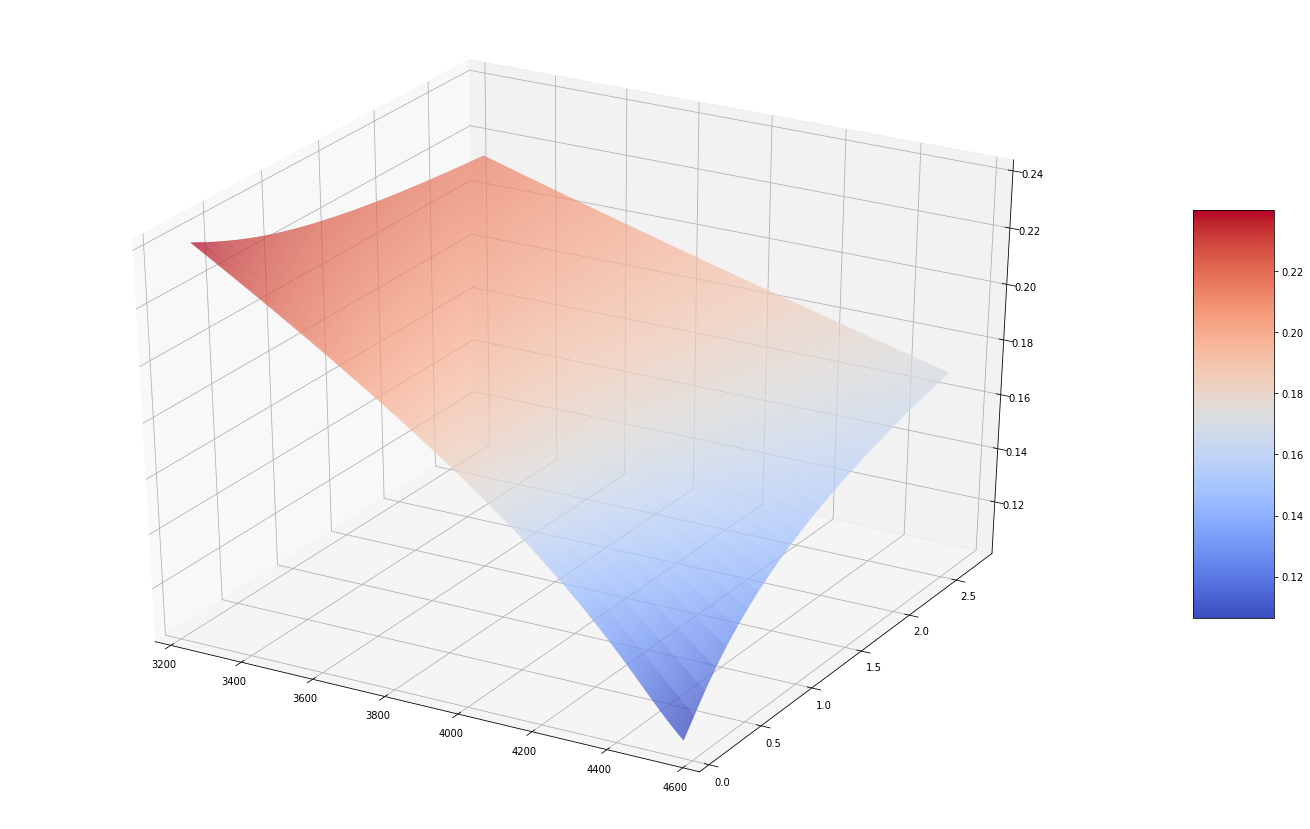

In [29]:
import numpy as np
import QuantLib as ql
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Utility function to plot vol surfaces (can pass in ql.BlackVarianceSurface objects too)
def plot_vol_surface(vol_surface, plot_years=np.arange(0.1,L.TTM[-1], 0.1), plot_strikes=np.arange(strikes[0], strikes[-1], 1)):
    fig = plt.figure(figsize=(25, 15))
    ax = fig.gca(projection='3d')

    X, Y = np.meshgrid(plot_strikes, plot_years)
    Z = np.array([vol_surface.blackVol(float(y), float(x)) 
                  for xr, yr in zip(X, Y) 
                      for x, y in zip(xr,yr) ]
                 ).reshape(len(X), len(X[0]))

    surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, linewidth=0.1,cmap=cm.coolwarm)

    fig.colorbar(surf, shrink=0.5, aspect=5)

# World State setup
today = calculation_date


# Setting up a Heston model with dummy parameters (roughly 10% constant BS vol)
theta, kappa, sigma, rho, v0 = model4.params()

process = ql.HestonProcess(yield_ts, dividend_ts, ql.QuoteHandle(ql.SimpleQuote(spot)), v0, kappa, theta, sigma, rho)

# Boilerplate to get to the Vol Surface object
heston_model = ql.HestonModel(process)
heston_handle = ql.HestonModelHandle(heston_model)
heston_vol_surface = ql.HestonBlackVolSurface(heston_handle)

# Plot the vol surface ...
plot_vol_surface(heston_vol_surface)

# FFT Calibrations

In [30]:
# Data manipulation
import numpy as np
import pandas as pd

# For calculation and solvinge quations/optimazation
import scipy.stats as ss
import scipy.optimize as scpo
from scipy import sparse
from scipy.fftpack import ifft
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from functools import partial

# Result Presenting
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import warnings; warnings.filterwarnings("ignore")

In [31]:
def fft(K, S0, r, T, cf): # interp support cubic 
    """ 
    K = vector of strike
    S0 = spot price scalar
    cf = characteristic function
    """
    N = 2**15                         # FFT more efficient for N power of 2
    B = 750                         # integration limit 
    
    dx = B/N
    x = np.arange(N) * dx

    weight = 3 + (-1)**(np.arange(N)+1) # Simpson weights
    weight[0] = 1; weight[N-1]=1

    dk = 2*np.pi/B
    b = N * dk /2
    ks = -b + dk * np.arange(N)

    integrand = np.exp(- 1j * b * np.arange(N)*dx) * cf(x - 0.5j) * 1/(x**2 + 0.25) * weight * dx/3
    integral_value = np.real( ifft(integrand)*N )
    spline_cub = interp1d(ks, integral_value, kind="cubic") # cubic will fit better than linear
    prices = S0 - np.sqrt(S0 * K) * np.exp(-r*T)/np.pi * spline_cub( np.log(S0/K) )
    
    return prices

In [32]:
class Heston_process():
    def __init__(self, mu=0.1, rho=0, sigma=0.2, theta=-0.1, kappa=0.1):
        """
        r: risk free constant rate
        rho: correlation between stock noise and variance noise (|rho| must be <=1)
        theta: long term mean of the variance process(positive)
        sigma: volatility coefficient(positive)
        kappa: mean reversion coefficient for the variance process(positive)
        """
        self.mu, self.rho, self.theta, self.sigma, self.kappa = mu, rho, theta, sigma, kappa

In [33]:

# Class to price the options with the Heston model by:
class Heston_pricer():
    
    def __init__(self, Option_info, Process_info ):
        """
        Process_info: a instance of "Heston_process.", which contains (mu, rho, sigma, theta, kappa)
        Option_info: of type Option_param, which contains (S0,K,T)
        """
        self.r = Process_info.mu              # interest rate
        self.sigma = Process_info.sigma       # Heston parameters
        self.theta = Process_info.theta       
        self.kappa = Process_info.kappa       
        self.rho = Process_info.rho           
        
        self.S0 = Option_info.S0          # current price
        self.v0 = Option_info.v0          # spot variance
        self.K = Option_info.K            # strike
        self.T = Option_info.T            # maturity(in years)
        self.exercise = Option_info.exercise
        self.payoff = Option_info.payoff
    
    # payoff function
    def payoff_f(self, S):
        if self.payoff == "call":
            Payoff = np.maximum( S - self.K, 0 )
        elif self.payoff == "put":    
            Payoff = np.maximum( self.K - S, 0 )  
        return Payoff
    
    # FFT method. It returns a vector of prices.
    def FFT(self, K): # K: strikes
        K = np.array(K)
        
        # Heston characteristic function (proposed by Schoutens 2004)
        def cf_Heston_good(u, t, v0, mu, kappa, theta, sigma, rho):
            xi = kappa - sigma*rho*u*1j
            d = np.sqrt( xi**2 + sigma**2 * (u**2 + 1j*u) )
            g1 = (xi+d)/(xi-d)
            g2 = 1/g1
            cf = np.exp( 1j*u*mu*t + (kappa*theta)/(sigma**2) * ( (xi-d)*t - 2*np.log( (1-g2*np.exp(-d*t))/(1-g2) ))\
                      + (v0/sigma**2)*(xi-d) * (1-np.exp(-d*t))/(1-g2*np.exp(-d*t)) )
            return cf
        
        cf_H_b_good = partial(cf_Heston_good, t=self.T, v0=self.v0, mu=self.r, theta=self.theta, 
                                  sigma=self.sigma, kappa=self.kappa, rho=self.rho)
        if self.payoff == "call":
            return fft(K, self.S0, self.r, self.T, cf_H_b_good)
        elif self.payoff == "put":        # put-call parity
            return fft(K, self.S0, self.r, self.T, cf_H_b_good) - self.S0 + K*np.exp(-self.r*self.T)

In [34]:
# A class that stores option parameters (in order to write BS/Heston class neatly)
class Option_param():  
    def __init__(self, S0=100, K=100, T=1, v0=0.04, payoff="call", exercise="European"):
        """
        S0: current stock price
        K: Strike price
        T: time to maturity
        v0: (optional) spot variance 
        exercise: European or American
        """
        self.S0, self.v0, self.K, self.T, self.exercise, self.payoff = S0, v0, K, T, exercise, payoff

In [35]:
def Return_df_Pricer(x,r,Q,ivmse):
    mse = 0
    rmse = 0
    aare = 0
    Heston_param = Heston_process(mu=r, rho=x[0], sigma=x[1], theta=x[2], kappa=x[3])
    for i in Q.unstack().index:
        prices, strikes, spreads = Q.loc[i].iloc[:,-2].values,Q.loc[i].index.values,1/(Q.loc[i].iloc[:,-3].values)
        opt_param = Option_param(S0=S0, K=strikes, T=i, v0=x[4], exercise="European", payoff="call" ) 
        Hest = Heston_pricer(opt_param, Heston_param) 
        prices_calib = Hest.FFT(strikes)
        mse =+ np.sum(spreads*(prices_calib - prices)**2)
        aare =+ np.sum(spreads * abs(prices_calib - prices)/prices)
    mse = mse/len(Q)
    rmse = np.sqrt(mse)
    aare = aare/len(Q) * 100
    df = pd.DataFrame([mse,aare,rmse,ivmse,int(len(Q))] + x.tolist(),index = ['MSE','AARE(in %)','RMSE','IVMSE','DATA POINTS','RHO','SIGMA','THETA','KAPPA','V0'],columns = ['Summary']).T
    return df

sl = np.array([rho,sigma,theta,kappa,v0])

In [36]:
%%time
Return_df_Pricer(sl,0,Q,error)

CPU times: user 284 ms, sys: 30.5 ms, total: 314 ms
Wall time: 323 ms


,MSE,AARE(in %),RMSE,IVMSE,DATA POINTS,RHO,SIGMA,THETA,KAPPA,V0
Summary,0.237374,0.002997,0.487211,0.000328,210.0,-0.905733,0.36396,0.046033,1.438834,0.024361


# SVI Parametrization

In [137]:
from scipy.optimize import minimize
import numpy as np


class svi_model:
    
    def __init__(self, data, init_adc, init_msigma, tol,strikes,T,IV,delta_k):
        
        self.init_msigma = init_msigma
        self.init_adc = init_adc
        self.tol = tol
        self.data = data
        self.T = T
        self.strikes = strikes
        self.IV = IV
        self.delta = delta_k
        self.optimization()

    def forward_price(self):
        
        """
        Forward or Spot Price
        """
        
        f = self.data
        return f

    def outter_function(self, params):
       
        """
        Outter optimisor
        """
       
        m, sigma = params
        sigma = max(0, sigma)
        adc_0 = self.init_adc
        adc_0 = [max(0,adc_0[0]),min(abs(adc_0[1]),abs(4*sigma)),min(min(adc_0[2],0),4*sigma)]
        f = self.forward_price()

        def inner_fun(params):
           
            """
            Inner Optimisor
            """
            
            a, d, c = params
            error_sum = 0.0
            xi = np.log(self.strikes/f)
            y = (xi-m)/sigma
            z = np.sqrt(y**2+1)
            error_sum = np.sum(np.array(a + d * y + c * z -
                                        np.array(self.IV)**2*self.T) ** 2)
            return error_sum
        bnds = (
            (0, max(np.array(self.IV))), (-4*sigma, 4*sigma), (0, 4*sigma))
        b = np.array(bnds, float)
        cons = (
            {'type': 'ineq', 'fun': lambda x: x[2]-abs(x[1])},
            {'type': 'ineq', 'fun': lambda x: 4*sigma-x[2]-abs(x[1])},
            #{'type': 'ineq', 'fun': lambda x: - x[1]/x[2] + 1},
            #{'type': 'ineq', 'fun': lambda x:  x[1]/x[2] + 1}
        )
        inner_res = minimize(inner_fun, adc_0, method='SLSQP', tol=1e-9,bounds = bnds,constraints = cons)
        
        a_star, d_star, c_star = inner_res.x
        self._a_star, self._d_star, self._c_star = inner_res.x

        sum = 0.0
        xi = np.log(self.strikes/f)
        y = (xi-m)/sigma
        z = np.sqrt(y**2+1)
        sum = np.sum(np.array(a_star + d_star * y + c_star *
                              z - np.array(self.IV)**2*self.T) ** 2)
        return sum

    def optimization(self):
        
        """
        Calibrator
        """

        outter_res = minimize(
            self.outter_function, self.init_msigma, method='Nelder-Mead', tol=self.tol)
        m_star, sigma_star = outter_res.x
        self._m_star, self._sigma_star = outter_res.x
        #obj = outter_res.fun
        calibrated_params = [self._a_star, self._d_star,
                             self._c_star, m_star, sigma_star]
        return calibrated_params

    def svi_vol(self,delta = 0):
       
        """
        SVI Volatility curve
        """

        f = self.forward_price()
        xi = np.log(self.strikes/f) + delta
        y = (xi-self._m_star)/self._sigma_star
        z = np.sqrt(y**2+1)
        omega = np.array(self._a_star + self._d_star * y + self._c_star * z)
        #sigma = np.sqrt(omega/self.T)
        #l = np.min(self.Dur_Condition())
        #if l < 0 :
        sigma = np.sqrt(self.JW_params()/self.T)
        f = interp1d(self.strikes,sigma,kind='cubic')
        stk_n = np.linspace(self.strikes.min(),self.strikes.max(),300)
        sigma = f(stk_n)
        return sigma
    
    def svi_vol2(self,delta = 0):
        """
        Made to be used with The jump wing parametrisation
        
        """
        
        xi = np.log(self.strikes/self.data) + delta
        y = (xi-self._m_star)/self._sigma_star
        z = np.sqrt(y**2+1)
        omega = np.array(self._a_star + self._d_star * y + self._c_star * z)
        return omega 
    
    def JW_params(self):
        """
        JW Parameters 
        """
        a,sigma,b,m,p = self.reinitialise_params()
        self.v = (a + b *(-p * m + np.sqrt(m**2+sigma**2)))/self.T
        self.w = self.v * self.T
        self.u = 1/np.sqrt(self.w) * (b/2) * (-m /np.sqrt(m**2+sigma**2) + p)
        self.p2 = 1/np.sqrt(self.w) * b * ( 1 - p )
        self.c = 1/np.sqrt(self.w) * b * ( 1 + p )
        self.v2 = (a + b * sigma * np.sqrt(1 - p**2))/self.T
        self.Reconversion()
        #self.init_msigma = [v2,p2]
        #self.init_adc = [v ,p2 * c * b , p2 * b ]
        return self.svi_vol2(0)
    
    def second_optimisation(self):
        
        """
        Calibrator
        """
        outter_res = minimize(
            self.Block_optimised, self.init_msigma, method='Nelder-Mead', tol=self.tol)
        m_star, sigma_star = outter_res.x
        self._m_star, self._sigma_star = outter_res.x
        #obj = outter_res.fun
        calibrated_params = [self._a_star, self._d_star,
                             self._c_star, m_star, sigma_star]
        return calibrated_params
    
    def Block_optimised(self,params):
        u,p,v,c = params 
        c = 2 * u + p
        v2 = v * (4 * p * c)/(p+c)**2
        return 0
    
    def reinitialise_params(self):
        
        #Retrieving initial parameters 
        
        self._a_star = self._a_star
        self._sigma_star = self._sigma_star
        self._b_star = self._c_star/self._sigma_star
        self._m_star = self._m_star
        self._p_star = np.round(self._d_star/(self._c_star),2)
        return self._a_star,self._sigma_star,self._b_star,self._m_star,self._p_star
    
    def Reconversion(self):
        
        #Reconverting to used Params
        
        self._b_star = .5 * np.sqrt(self.w) * (self.c + self.p2)
        self._p_star = 1 - (self.p2 * np.sqrt(self.w))/self._b_star
        self.Beta_star = self._p_star - 2 * self.u * np.sqrt(self.w)/self._b_star
        self.alpha_star = np.sign(self.Beta_star) * np.sqrt(1/(self.Beta_star**2) - 1)
        self._m_star = ((self.v - self.v2)*self.T)/(self._b_star *(-self._p_star + np.sign(self.alpha_star)*np.sqrt(1+self.alpha_star**2)\
                                                                  - self.alpha_star * np.sqrt(1-self._p_star**2)))
        
        self._a_star = self.v2 * self.T - self._b_star * self._sigma_star * np.sqrt(1-self._p_star**2)
        self._sigma_star = self._m_star * self.alpha_star#,(self.v * self.T - self._a_star)/(self._b_star))
        self._d_star = self._p_star * self._b_star * self._sigma_star
        self._c_star = self._b_star * self._sigma_star        
        
    def dminus(self,x):
        vsqrt = np.sqrt(x/self.T)
        y = np.log(self.strikes/self.data)
        return -y/vsqrt - 0.5*vsqrt

        
    def Dur_Condition(self):
        
        #Fokker-Plan Condition
        
        
        dk = (np.max(np.log(self.strikes/self.data))-np.min(np.log(self.strikes/self.data)))/len(self.strikes)
        k = np.log(self.strikes/self.data)
        A = self.svi_vol2(dk)
        B = self.svi_vol2(-dk)
        dSvi = (A - B) / (2 * dk)
        Svi = self.svi_vol2()
        ddSvi = (A - 2 * Svi  + B )/(dk**2)
        dm = self.dminus(Svi)
        g = ((np.sqrt(2 * np.pi * Svi))**-1) * ((1 - k * dSvi /(Svi))**2 - Svi**2 * (dSvi**2)/4  + Svi * ddSvi)*np.exp(-0.5*dm**2)
        return g
        
        

In [124]:
def Arbitrager(data, init_adc, init_msigma,strikes,T,IV):
    dk = (np.max(np.log(strikes/data))-np.min(np.log(strikes/data)))/len(strikes)
    k = np.log(strikes/data)
    A = svi_model(data,init_adc,init_msigma,1e-9,strikes,t,IV,dk).svi_vol(dk)
    B = svi_model(data,init_adc,init_msigma,1e-9,strikes,t,IV,-dk).svi_vol(-dk)
    dSvi = (A - B) / (2 * dk)
    Svi = svi_model(data,init_adc,init_msigma,1e-9,strikes,t,IV,0).svi_vol()
    ddSvi = (A - 2 * Svi  + B )/(dk**2)
    g = (1 - k * dSvi /(Svi))**2 - Svi**2 * (dSvi**2)/4  + Svi * ddSvi
    return g
    

In [128]:
#Initial_params
def initialist(parameters,strikes,S0):
    a = 0 + (parameters[2]/2)*(1-parameters[0]**2)
    b = parameters[1] * parameters[2]/2
    sigma = np.sqrt(1-parameters[0]**2)/parameters[1]
    c = b*sigma
    d = parameters[0] * b * sigma
    m = - parameters[0]/parameters[1]
    return a,d,c,m,sigma#,Z

#sl1 = [0.0131, -0.1366, 0.7472, 1.5826, 0.0106]
init = initialist(sl,strikes,S0)
init_1 = init[:3]
init_2 = init[3:]
print(init_1,init_2)

(0.00413485200779595, -0.008835843694039055, 0.009755466924338574) (2.4885511459367287, 1.1645510104735353)


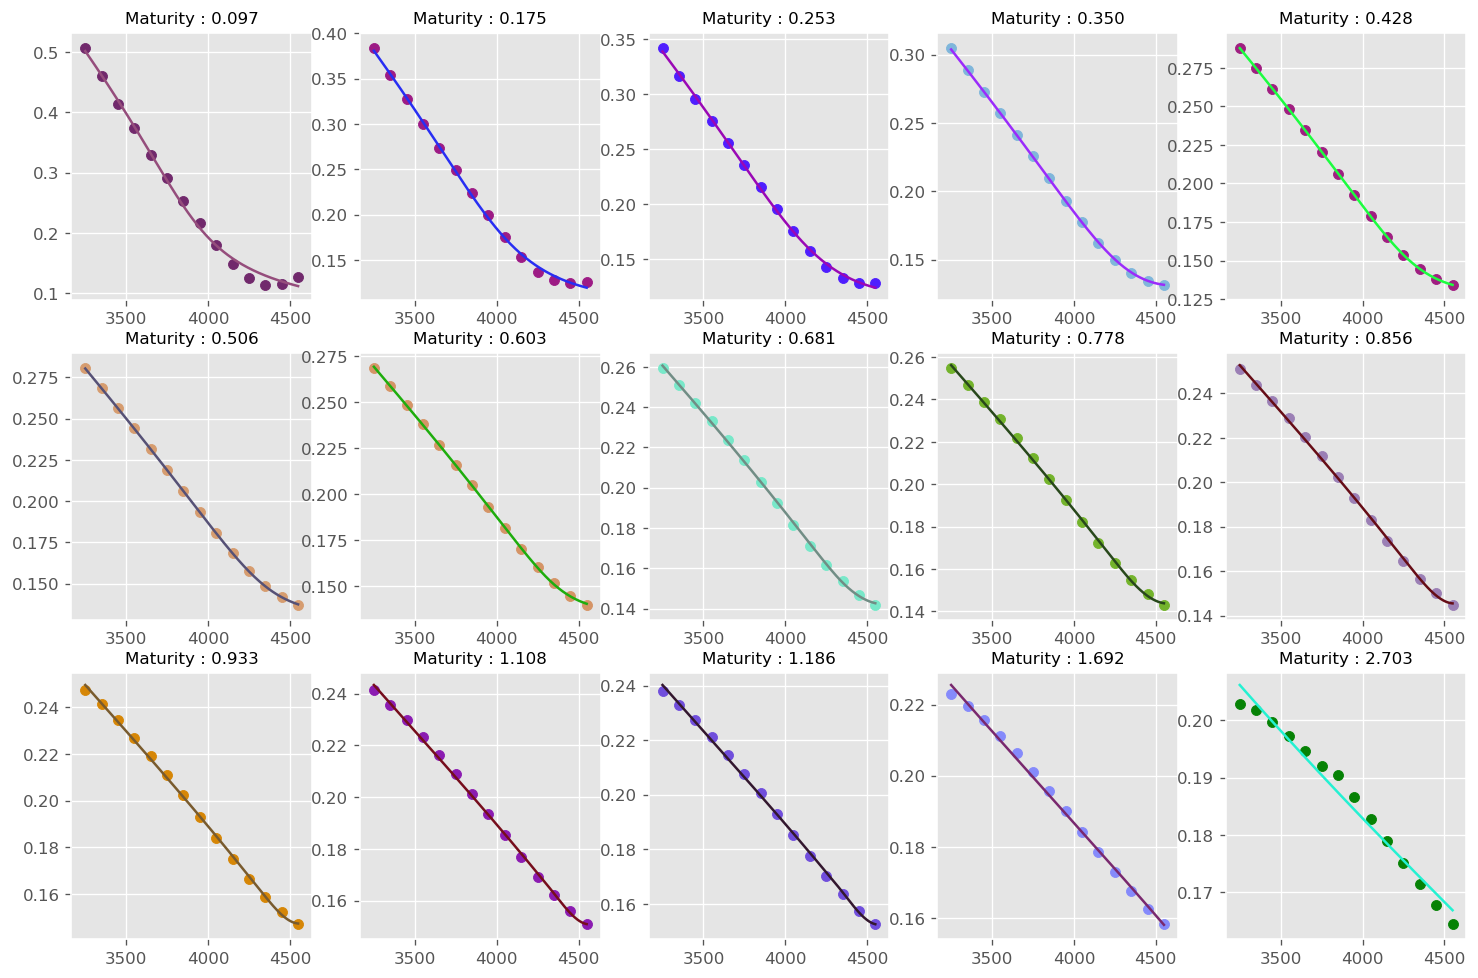

In [139]:
fig, axes = plt.subplots(nrows=3, ncols=5, dpi=120, figsize=(15,10))
fig.canvas.set_window_title('SVI Parametrization')
strikes = np.array(strikes)
stk_n = np.linspace(strikes.min(),strikes.max(),300)
for i, ax in enumerate(axes.flatten()): 
    t = L.TTM.unique()[i]
    IV = Q.loc[t]['Implied Volatility'].values
    data = svi_model(S0,init_1,init_2,1e-9,strikes,t,IV,0).svi_vol(0)
    ax.plot(stk_n,data,color = np.random.rand(3,))
    ax.plot()
    ax.scatter(strikes,IV,color = np.random.rand(3,))
    ax.set_title('Maturity : %1.3f'%t,fontsize=10)

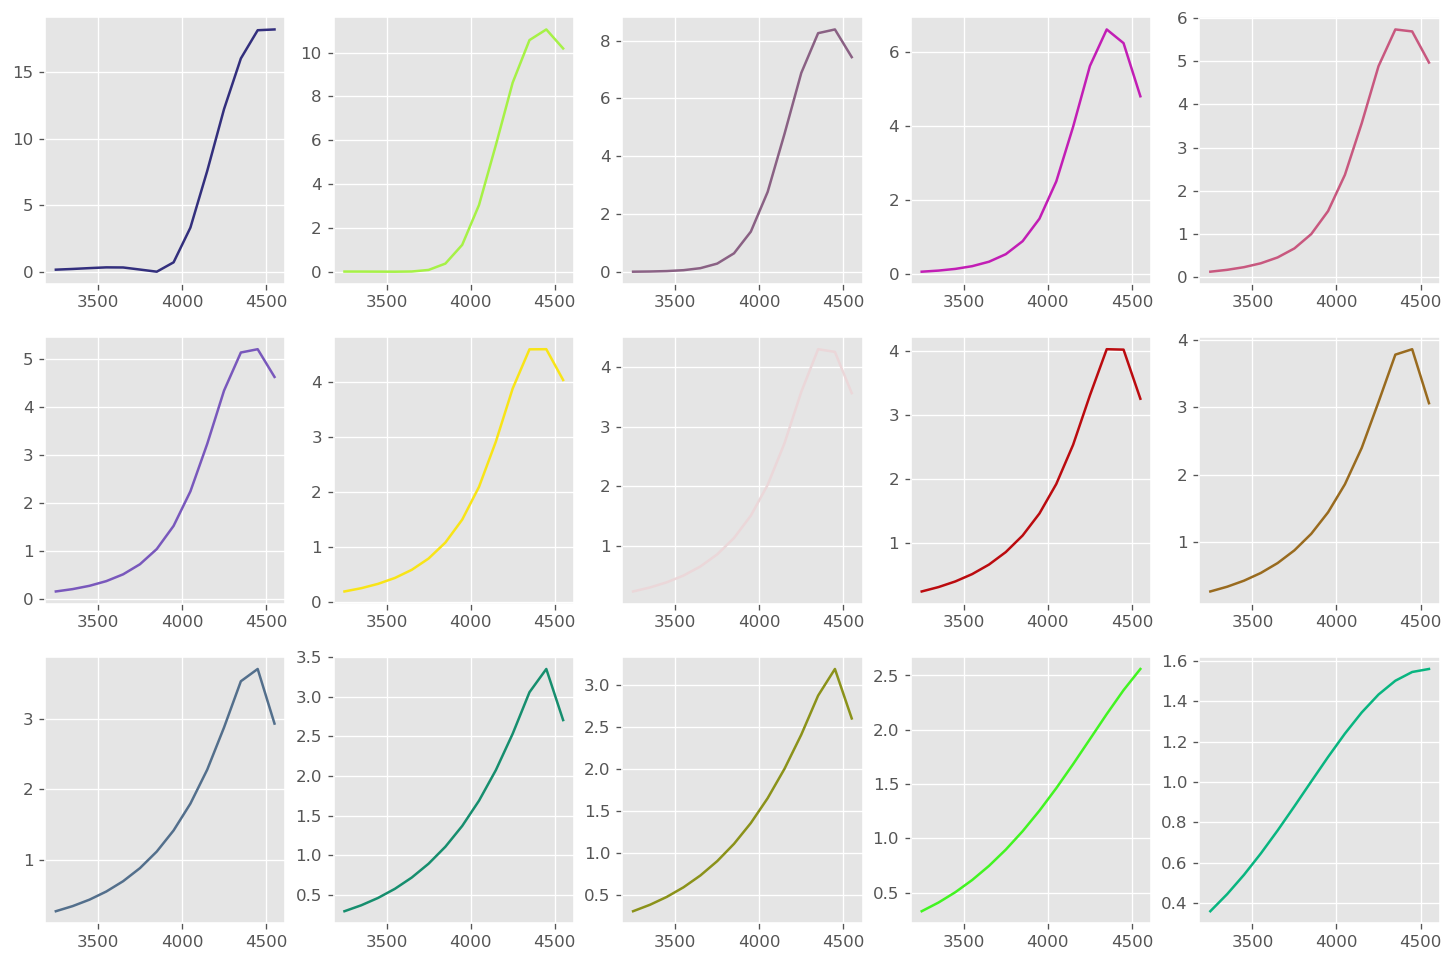

In [140]:
fig, axes = plt.subplots(nrows=3, ncols=5, dpi=120, figsize=(15,10))
fig.canvas.set_window_title('SVI Parametrization')
strikes = np.array(strikes)
for i, ax in enumerate(axes.flatten()): 
    t = L.TTM.unique()[i]
    IV = Q.loc[t]['Implied Volatility'].values
    g = svi_model(S0,init_1,init_2,1e-9,strikes,t,IV,0).Dur_Condition()
    ax.plot(strikes,g,color = np.random.rand(3,))
    ax.plot()

# SSVI : To be Continued

In [192]:
def phi(theta, params):
    gamma, eta, sigma, rho = params
    return eta / pow(theta, gamma)

def SSVI(x, t, params):
    gamma, eta, sigma, rho = params
    theta = sigma*sigma*t
    p = phi(theta, params)
    return 0.5*theta*(1.+rho*p*x+np.sqrt((p*x+rho)*(p*x+rho)+1.-rho*rho))

def SSVI1(x, t, params):
    ## First derivative with respect to x
    gamma, eta, sigma, rho = params
    theta = sigma*sigma*t
    p = phi(theta, params)
    return 0.5*theta*p*(p*x+rho*np.sqrt(p*p*x*x+2.*p*rho*x+1.)+rho)/np.sqrt(p*p*x*x+2.*p*rho*x+1.)

def SSVI2(x, t, params):
    ## Second derivative with respect to x
    gamma, eta, sigma, rho = params
    theta = sigma*sigma*t
    p = phi(theta, params)
    return 0.5*theta*p*p*(1.-rho*rho)/ ((p*p*x*x + 2.*p*rho*x + 1.)*np.sqrt(p*p*x*x+2.*p*rho*x+1.))
    
def SSVIt(x, t, params):
    ## First derivative with respect to t, by central difference
    eps = 0.0001
    return (SSVI(x,t+eps,params) - SSVI(x,t-eps,params))/(2.*eps)

def g(x, t, params):
    w = SSVI(x,t,params)
    w1 = SSVI1(x,t,params)
    w2 = SSVI2(x,t,params)
    return (1.-0.5*x*w1/w)*(1.-0.5*x*w1/w) - 0.25*w1*w1*(0.25 + 1./w) + 0.5*w2
    
def dminus(x, t, params):
    vsqrt = np.sqrt(SSVI(x,t,params))
    return -x/vsqrt - 0.5*vsqrt
    
def densitySSVI(x, t, params):
    dm = dminus(x,t,params)
    return g(x,t,params)*np.exp(-0.5*dm*dm)/np.sqrt(2.*np.pi*SSVI(x,t,params))

def SSVI_LocalVarg(x, t, params):
    ## Compute the equivalent SSVI local variance
    return SSVIt(x,t,params) / g(x,t,params)


In [ ]:
def constraint2(x, t, params):
    

In [ ]:
cst = {'type': 'ineq', 'fun': lambda x: (x[2]*x[2]*(t+1/252) - x[2]*x[2]*(t-1/252))/(2/252)},
      {'type': 'ineq', 'fun': lambda x: 4*sigma-x[2]-abs(x[1])}

In [ ]:
 minimize(inner_fun, adc_0, method='SLSQP', tol=1e-9,bounds = bnds,constraints = cons)

In [193]:
sigma, gamma, eta, rho = 0.2, 0.4, 0.2, -0.4
xx, TT = np.linspace(-1., 1., 20), np.linspace(0.1, 2., 20)

print("Consistency check to avoid static arbitrage: ", (gamma - 0.25*(1.+np.abs(rho))>0.))
params = gamma, eta, sigma, rho

localVarianceSSVI = [[SSVI_LocalVarg(x, t, params) for x in xx] for t in TT]

Consistency check to avoid static arbitrage:  True


In [ ]:
 minimize(inner_fun, adc_0, method='SLSQP', tol=1e-9,bounds = bnds,constraints = cons)

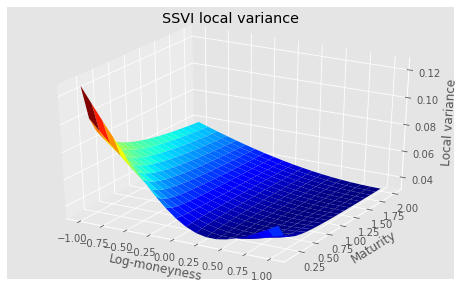

In [194]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca(projection='3d')
xxx, TTT = np.meshgrid(xx, TT)
localVarianceSSVI = np.array(localVarianceSSVI)
ax.plot_surface(xxx, TTT, localVarianceSSVI, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)
ax.set_xlabel("Log-moneyness")
ax.set_ylabel("Maturity")
ax.set_zlabel("Local variance")
ax.set_title("SSVI local variance")
plt.show()

# Black Sholes Using Characteristic Functions

In [42]:
import numpy as np
from scipy import stats, special, integrate

In [43]:
%%time 

def char_func(x,s,vol,t=1,r=0,L='0'):
    var = vol*vol*t
    if L == '0':
        mean = np.log(s) + (r - 0.5*vol*vol) * t
        w = np.exp(1j*x*mean - x*x*var*0.5)
    else :
        mean =  (r - 0.5*vol*vol) * t
        w = np.exp(mean * (1 + x * 1j) + .5 * var * (1 + x * 1j )**2 )
    return w

def call_value(s,k,vol,t=1,r=0):
    
    def integrand(x,s,k,vol,t=1,r=0,L='1'):
        I = np.exp(-1j*x*np.log(k/s)) * char_func(x,s,vol,t,r,L)/(1j*x)
        return I.real

    def integrand2(x,s,k,vol,t=1,r=0,L='0'):
        I = np.exp(-1j*x*np.log(k)) * char_func(x,s,vol,t,r,L)/(1j*x)
        return I.real

    int1 = integrate.quad(integrand,0,np.inf,args=(s,k,vol,t,r))
    int1 = 0.5 + int1[0]/np.pi

    int2 = integrate.quad(integrand2,0,np.inf,args=(s,k,vol,t,r))
    int2 = 0.5 + int2[0]/np.pi
    
    H = int2*np.exp(-0.05*1)/s
            
    return  s*int1 - np.exp(-r*t)*k*int2,int1,int2,H

print(call_value(1,1,0.2))

(0.07965567455405798, 0.539827837277029, 0.460172162722971, 0.43772930151822065)
CPU times: user 2.48 ms, sys: 512 µs, total: 2.99 ms
Wall time: 3.11 ms


In [44]:
%%time 

def char_func(x,s,vol,t=1,r=0):
    mean = np.log(s) + (r - 0.5*vol*vol) * t
    var = vol*vol*t
    w = np.exp(1j*x*mean - x*x*var*0.5)
    return w

def call_value(s,k,vol,t=1,r=0):
    
    def integrand(x,s,k,vol,t=1,r=0):
        I = np.exp(-1j*x*np.log(k)) * char_func(x-1j,s,vol,t,r)/((1j * x)*char_func(-1j,s,vol,t,r))
        return I.real

    def integrand2(x,s,k,vol,t=1,r=0):
        I = np.exp(-1j*x*np.log(k)) * char_func(x,s,vol,t,r)/(1j * x)
        return I.real

    int1 = integrate.quad(integrand,0,np.inf,args=(s,k,vol,t,r))
    int1 = 0.50 + int1[0]/(np.pi)

    int2 = integrate.quad(integrand2,0,np.inf,args=(s,k,vol,t,r))
    int2 = 0.50 + int2[0]/(np.pi)
    
    H = int2*np.exp(-0.05*(1))/s
            
    return s*int1 - np.exp(-r*t)*k*int2,int1,int2,H

print(call_value(1,1,0.2))

(0.07965567455405798, 0.539827837277029, 0.460172162722971, 0.43772930151822065)
CPU times: user 3.59 ms, sys: 202 µs, total: 3.79 ms
Wall time: 3.69 ms
